# 4️⃣ Machine Learning
**designed by:** [datamover.ai](https://www.datamover.ai)

In [1]:
# Load libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from matplotlib.gridspec import GridSpec
# plot calibration curve
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from sklearn.compose import ColumnTransformer
from sklearn.discriminant_analysis import (LinearDiscriminantAnalysis,
                                           QuadraticDiscriminantAnalysis)
from sklearn.ensemble import (AdaBoostClassifier, RandomForestClassifier,
                              VotingClassifier)
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (GridSearchCV, RandomizedSearchCV,
                                     train_test_split)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (LabelEncoder, OneHotEncoder, OrdinalEncoder,
                                   StandardScaler)
from sklearn.svm import SVC

# import helper function made ad-hoc
from c3_helpers import chain_snap, classification_report
from c4_helpers import check_grid_search_hyperparameters, robust_rfecv

# Set random seed
np.random.seed(42)

In [2]:
# consider features which they look promising
numerical_features = ["Age", "final weight"]
nominal_features = [
    "Sex",
    "Workclass-approx",
    "MaritalStatus-approx",
    "Occupation-approx",
    "Relationship-approx",
    "Ethnicity-approx",
    "Country-approx",
    "Capital Invested",
]
ordinal_features = ["Education-approx", "Hours per week-approx"]
TARGET = "Income"

In [3]:
# load csv
data = (
    pd.read_parquet("./data/data_train_cleaned.parquet")
    .filter(items=numerical_features + nominal_features + ordinal_features + [TARGET])
    .pipe(chain_snap, fn=lambda x: x.shape, msg="Size dataframe")
    .replace(to_replace="?", value=np.nan)  # replace " ?" with np.NaN
    .pipe(
        chain_snap, fn=lambda x: x.isna().sum().sum(), msg="Count NaNs post processing"
    )
)

data.info()

Size dataframe: (26016, 13)
Count NaNs post processing: 2982
<class 'pandas.core.frame.DataFrame'>
Int64Index: 26016 entries, 0 to 26047
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   Age                    26016 non-null  Int8    
 1   final weight           26016 non-null  Int64   
 2   Sex                    26016 non-null  category
 3   Workclass-approx       24525 non-null  category
 4   MaritalStatus-approx   26016 non-null  category
 5   Occupation-approx      24525 non-null  category
 6   Relationship-approx    26016 non-null  object  
 7   Ethnicity-approx       26016 non-null  category
 8   Country-approx         26016 non-null  category
 9   Capital Invested       26016 non-null  category
 10  Education-approx       26016 non-null  category
 11  Hours per week-approx  26016 non-null  category
 12  Income                 26016 non-null  category
dtypes: Int64(1), Int8(1), category

In [4]:
# split data in train and dev set and use dev for error analysis and calibration if necessary
X_train, X_dev, y_train, y_dev = train_test_split(
    data.drop(TARGET, axis=1), data[TARGET], test_size=0.2, random_state=42
)

# process y in 0/1
y_train = y_train.replace(to_replace="<=50K", value=0).replace(
    to_replace=">50K", value=1
)

y_dev = y_dev.replace(to_replace="<=50K", value=0).replace(to_replace=">50K", value=1)

# reset index of X and y as it is not important for the error analysis
X_train, X_dev = X_train.reset_index(drop=True), X_dev.reset_index(drop=True)
y_train, y_dev = y_train.reset_index(drop=True), y_dev.reset_index(drop=True)

# initialize classifiers list
clf_list = []

https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html

In [5]:
def construct_preprocessor(
    numerical_features: list, nominal_features: list, ordinal_features: list
) -> ColumnTransformer:
    """Construct the preprocessor to be used in the pipeline

    Args:
        numerical_features (list): list of numerical features contained in the dataset
        nominal_features (list): list of nominal features contained in the dataset
        ordinal_features (list): list of ordinal features contained in the dataset

    Returns:
        ColumnTransformer: preprocessor to be used in the pipeline
    """

    numerical_transformer = Pipeline(
        steps=[
            ("num_imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler()),
        ]
    )

    nominal_transformer = Pipeline(
        steps=[
            ("nom_imputer", SimpleImputer(strategy="most_frequent")),
            ("nominal_encoder", OneHotEncoder(handle_unknown="error", drop="first")),
        ]
    )

    categories_order = [
        ["HS-grad", "Some-college", "Higher-education"],
        ["Part-time", "Full-time", "Over-time"],
    ]
    ordinal_transformer = Pipeline(
        steps=[
            ("ord_imputer", SimpleImputer(strategy="most_frequent")),
            ("ordinal_encoder", OrdinalEncoder(categories=categories_order)),
        ]
    )

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numerical_transformer, numerical_features),
            ("nom", nominal_transformer, nominal_features),
            ("ord", ordinal_transformer, ordinal_features),
        ]
    )

    return preprocessor

In [6]:
preprocessor = construct_preprocessor(
    numerical_features, nominal_features, ordinal_features
)
baseline_model = LogisticRegression(class_weight="balanced")

ml_baseline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("LR", baseline_model),
    ]
)

ml_baseline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'final weight']),
                                                 ('nom',
                                                  Pipeline(steps=[('nom_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('nominal_encoder',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['Sex', 'Workclass-approx',
                                                   'Marit...
                                                   'Country-approx',
                                                   'Capital Invested']),
                                                 ('ord',
                                                  Pipeline(steps=[('ord_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinal_encoder',
                                                                   OrdinalEncoder(categories=[['HS-grad',
                                                                                               'Some-college',
                                                                                               'Higher-education'],
                                                                                              ['Part-time',
                                                                                               'Full-time',
                                                                                               'Over-time']]))]),
                                                  ['Education-approx',
                                                   'Hours per week-approx'])])),
                ('LR', LogisticRegression(class_weight='balanced'))])

In [7]:
# set hyperparameter range
param_grid = {
    "LR__C": np.linspace(0.01, 0.5, 10),
}

# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
scoring = "f1"
gridCV = GridSearchCV(
    estimator=ml_baseline,
    param_grid=param_grid,
    n_jobs=-1,
    cv=3,
    verbose=0,
    refit=True,
    scoring=scoring,
)

_ = gridCV.fit(X_train, y_train)

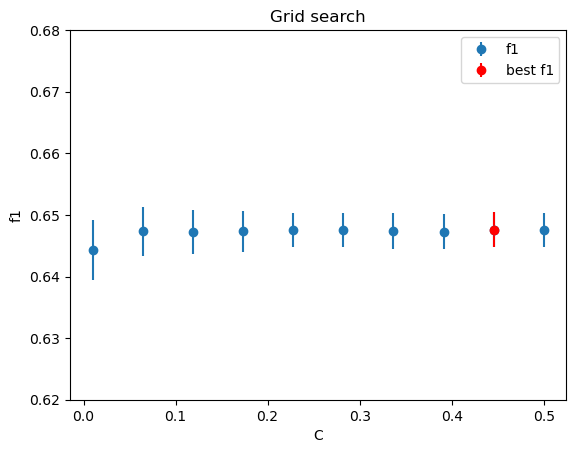

In [8]:
# plot mean_test_score vs param_Logreg__C with std_test_score as error bar
best_index = np.argmax(gridCV.cv_results_["mean_test_score"])
plt.errorbar(
    list(gridCV.cv_results_["param_LR__C"]),
    list(gridCV.cv_results_["mean_test_score"]),
    yerr=gridCV.cv_results_["std_test_score"],
    fmt="o",
    label="f1",
)
plt.errorbar(
    list(gridCV.cv_results_["param_LR__C"])[best_index],
    list(gridCV.cv_results_["mean_test_score"])[best_index],
    yerr=gridCV.cv_results_["std_test_score"][best_index],
    fmt="o",
    color="red",
    label="best f1",
)
plt.xlabel("C")
plt.ylabel("f1")
plt.title("Grid search")
plt.ylim([0.62, 0.68])
plt.legend()
plt.show()

In [9]:
# check grid search hyperparameters if they are in the range limit
check_grid_search_hyperparameters(gridCV, param_grid)

# get mean score of train and dev set
print(
    f"o Mean {scoring} score of the best_estimator on the train set: {np.mean(gridCV.best_score_):.3f})"
)

# Display best hyperparameters
print("o Best hyperparameters:")
display(pd.DataFrame(gridCV.best_params_, index=[0]))

# Generate classification report
model_performance = classification_report(
    y_true=y_dev,
    y_pred=gridCV.predict(X_dev),
    label="Baseline",
    show_description=False,
)

clf_list.append((gridCV.best_estimator_, "logistic regression"))

o Mean f1 score of the best_estimator on the train set: 0.648)
o Best hyperparameters:


,LR__C
0,0.445556


In [10]:
ml_candidate_SVC = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("SVC", SVC(class_weight="balanced", probability=True)),
    ]
)
ml_candidate_SVC

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'final weight']),
                                                 ('nom',
                                                  Pipeline(steps=[('nom_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('nominal_encoder',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['Sex', 'Workclass-approx',
                                                   'Marit...
                                                   'Ethnicity-approx',
                                                   'Country-approx',
                                                   'Capital Invested']),
                                                 ('ord',
                                                  Pipeline(steps=[('ord_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinal_encoder',
                                                                   OrdinalEncoder(categories=[['HS-grad',
                                                                                               'Some-college',
                                                                                               'Higher-education'],
                                                                                              ['Part-time',
                                                                                               'Full-time',
                                                                                               'Over-time']]))]),
                                                  ['Education-approx',
                                                   'Hours per week-approx'])])),
                ('SVC', SVC(class_weight='balanced'))])

In [11]:
# NOTE: this cell takes a while to run
# set hyperparameter range
param_grid = {
    "SVC__C": np.linspace(0.01, 0.5, 10),
    "SVC__kernel": ["linear", "rbf"],
}

# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
scoring = "f1"
gridCV = GridSearchCV(
    estimator=ml_candidate_SVC,
    param_grid=param_grid,
    n_jobs=-1,
    cv=3,
    verbose=0,
    refit=True,
    scoring=scoring,
)

_ = gridCV.fit(X_train, y_train)

In [12]:
# check grid search hyperparameters if they are in the range limit
check_grid_search_hyperparameters(gridCV, param_grid)

# get mean score of train and dev set
print(
    f"o Mean {scoring} score of the best_estimator on the train set: {np.mean(gridCV.best_score_):.3f})"
)

# Display best hyperparameters
print("o Best hyperparameters:")
display(pd.DataFrame(gridCV.best_params_, index=[0]))

# Generate classification report
model_performance = pd.merge(
    model_performance,
    classification_report(
        y_true=y_dev,
        y_pred=gridCV.predict(X_dev),
        label="pipeline SVC",
        show_description=False,
    ),
    left_index=True,
    right_index=True,
)

clf_list.append((gridCV.best_estimator_, "support vector machine"))

o Mean f1 score of the best_estimator on the train set: 0.645)
o Best hyperparameters:


,SVC__C,SVC__kernel
0,0.118889,rbf


### Feature selection using Recursive Feature Elimination

In [13]:
# process data to feed to RFECV
preprocessing_pipe = Pipeline([("preprocessor", preprocessor)])
X_numpy = preprocessing_pipe.fit_transform(X_train)

# extract feature names from pipeline [stored as list of arrays]
numerical_features_encoded = numerical_features
nominal_features_encoded = list(
    preprocessing_pipe.named_steps["preprocessor"]
    .named_transformers_["nom"]
    .named_steps["nominal_encoder"]
    .get_feature_names_out(nominal_features)
)
ordinal_features_encoded = list(
    preprocessing_pipe.named_steps["preprocessor"]
    .named_transformers_["ord"]
    .named_steps["ordinal_encoder"]
    .get_feature_names_out(ordinal_features)
)

# Create dataframe with encoded features for RFE
X_rfe = pd.DataFrame(
    X_numpy,
    columns=numerical_features_encoded
    + nominal_features_encoded
    + ordinal_features_encoded,
)

X_rfe.head()

,Age,final weight,Sex_Male,Workclass-approx_government-jobs,MaritalStatus-approx_Single,Occupation-approx_Manual-labor,Relationship-approx_Other,Relationship-approx_Wife,Ethnicity-approx_White,Country-approx_United-States,Capital Invested_yes,Education-approx,Hours per week-approx
0,2.084969,-0.345607,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
1,1.571642,-0.650118,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0
2,-0.555001,-1.053340,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0
3,0.838317,-0.424262,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0
4,2.231634,0.362513,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,2.0,1.0


rfecv for classification problem with 4 ML models with f1 score


,optimal_n_features,highest_performance,score
LogisticRegression,11,0.63,f1
AdaBoostClassifier,8,0.55,f1
LinearDiscriminantAnalysis,13,0.54,f1
RandomForestClassifier,12,0.51,f1


,LogisticRegression,AdaBoostClassifier,LinearDiscriminantAnalysis,RandomForestClassifier,intersection
0,Age,Age,Age,Age,Age
1,Capital Invested_yes,Capital Invested_yes,Capital Invested_yes,Capital Invested_yes,Capital Invested_yes
2,Country-approx_United-States,Country-approx_United-States,Country-approx_United-States,Country-approx_United-States,Country-approx_United-States
3,Education-approx,Education-approx,Education-approx,Education-approx,Education-approx
4,Hours per week-approx,Hours per week-approx,Ethnicity-approx_White,Ethnicity-approx_White,Hours per week-approx
5,MaritalStatus-approx_Single,Occupation-approx_Manual-labor,Hours per week-approx,Hours per week-approx,Occupation-approx_Manual-labor
6,Occupation-approx_Manual-labor,Relationship-approx_Other,MaritalStatus-approx_Single,MaritalStatus-approx_Single,Relationship-approx_Other
7,Relationship-approx_Other,Relationship-approx_Wife,Occupation-approx_Manual-labor,Occupation-approx_Manual-labor,NaN
8,Relationship-approx_Wife,NaN,Relationship-approx_Other,Relationship-approx_Other,NaN
9,Sex_Male,NaN,Relationship-approx_Wife,Sex_Male,NaN


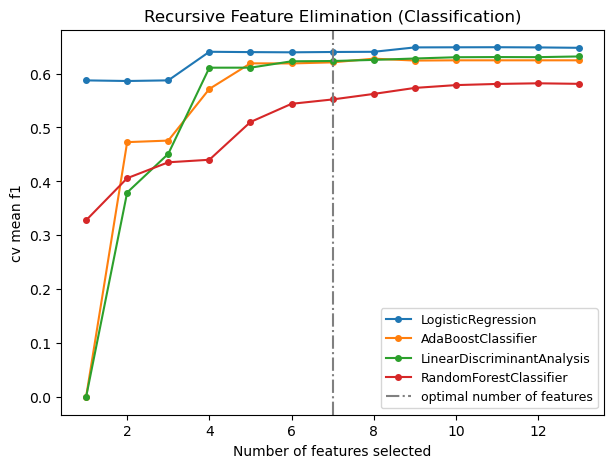

In [14]:
clf = [
    LogisticRegression(max_iter=1000, C=0.227778, class_weight="balanced"),
    AdaBoostClassifier(n_estimators=20),
    LinearDiscriminantAnalysis(),
    RandomForestClassifier(n_estimators=50, class_weight="balanced"),
]

df_summary, df_feature, fig = robust_rfecv(
    X=X_rfe, y=y_train, model_list=clf, scoring="f1", n_jobs=-2, show=True
)

# Note: all 4 models have similar performance with a different set of features

display(df_feature)

In [15]:
# Test Baseline Model using subset of features
numerical_features_c1 = ["Age"]
nominal_features_c1 = [
    "Occupation-approx",
    "Relationship-approx",
    "Country-approx",
    "Capital Invested",
]
ordinal_features_c1 = ["Education-approx", "Hours per week-approx"]

# "Ethnicity-approx", "Sex", "Workclass-approx", "MaritalStatus-approx", "final weight", are discarded

preprocessor_c1 = construct_preprocessor(
    numerical_features_c1, nominal_features_c1, ordinal_features_c1
)

# define pipeline with subset of features based on RFECV and baseline model
ml_pipeline_c1 = Pipeline(
    steps=[
        ("preprocessor", preprocessor_c1),
        ("LR", baseline_model),
    ]
)

# inspect pipeline
ml_pipeline_c1

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age']),
                                                 ('nom',
                                                  Pipeline(steps=[('nom_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('nominal_encoder',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['Occupation-approx',
                                                   'Relationship-approx',
                                                   'Country-approx',
                                                   'Capital Invested']),
                                                 ('ord',
                                                  Pipeline(steps=[('ord_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinal_encoder',
                                                                   OrdinalEncoder(categories=[['HS-grad',
                                                                                               'Some-college',
                                                                                               'Higher-education'],
                                                                                              ['Part-time',
                                                                                               'Full-time',
                                                                                               'Over-time']]))]),
                                                  ['Education-approx',
                                                   'Hours per week-approx'])])),
                ('LR', LogisticRegression(class_weight='balanced'))])

In [16]:
param_grid = {
    "LR__C": np.linspace(0.01, 0.5, 10),
}

gridCV = GridSearchCV(
    estimator=ml_pipeline_c1,
    param_grid=param_grid,  # same as baseline
    n_jobs=-1,
    cv=3,
    verbose=0,
    refit=True,
    scoring=scoring,
)

_ = gridCV.fit(X_train, y_train)

# check grid search hyperparameters if they are in the range limit
check_grid_search_hyperparameters(gridCV, param_grid)

# get mean score of train and dev set
print(
    f"o Mean {scoring} score of the best_estimator on the train set: {np.mean(gridCV.best_score_):.3f})"
)

# Display best hyperparameters
print("o Best hyperparameters:")
display(pd.DataFrame(gridCV.best_params_, index=[0]))

# Generate classification report
model_performance = pd.merge(
    model_performance,
    classification_report(
        y_true=y_dev,
        y_pred=gridCV.predict(X_dev),
        label="LR with subset of features",
        show_description=False,
    ),
    left_index=True,
    right_index=True,
)

# append model to list
clf_list.append((gridCV.best_estimator_, "logistic regression (subset of features)"))

o Mean f1 score of the best_estimator on the train set: 0.648)
o Best hyperparameters:


,LR__C
0,0.445556


In [17]:
# try case with all features and ensemble of models
ensemble = VotingClassifier(
    estimators=[
        ("LR", LogisticRegression(max_iter=1000, class_weight="balanced")),
        ("Ada", AdaBoostClassifier()),
        ("LDA", LinearDiscriminantAnalysis()),
        ("RF", RandomForestClassifier(class_weight="balanced")),
        ("QDA", QuadraticDiscriminantAnalysis()),
    ]
)

# define pipeline with
ml_pipeline_ensemble = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("ensemble", ensemble),
    ]
)

# inspect pipeline
ml_pipeline_ensemble

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'final weight']),
                                                 ('nom',
                                                  Pipeline(steps=[('nom_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('nominal_encoder',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['Sex', 'Workclass-approx',
                                                   'Marit...
                                                                                              ['Part-time',
                                                                                               'Full-time',
                                                                                               'Over-time']]))]),
                                                  ['Education-approx',
                                                   'Hours per week-approx'])])),
                ('ensemble',
                 VotingClassifier(estimators=[('LR',
                                               LogisticRegression(class_weight='balanced',
                                                                  max_iter=1000)),
                                              ('Ada', AdaBoostClassifier()),
                                              ('LDA',
                                               LinearDiscriminantAnalysis()),
                                              ('RF',
                                               RandomForestClassifier(class_weight='balanced')),
                                              ('QDA',
                                               QuadraticDiscriminantAnalysis())]))])

In [18]:
param_grid = {
    "ensemble__LR__C": np.linspace(0.01, 0.5, 10),
    "ensemble__Ada__n_estimators": list(range(1, 100)),
    "ensemble__Ada__learning_rate": np.linspace(0.01, 0.5, 10),
    "ensemble__RF__n_estimators": list(range(1, 100)),
    "ensemble__RF__max_depth": list(range(1, 10)),
    "ensemble__voting": ["hard", "soft"],
    "ensemble__weights": [np.random.uniform(low=0, high=1, size=5) for i in range(10)],
}

gridCV = RandomizedSearchCV(
    estimator=ml_pipeline_ensemble,
    param_distributions=param_grid,  # same as baseline
    n_jobs=-1,
    cv=3,
    verbose=1,
    n_iter=100,
    refit=True,
    scoring=scoring,
)

_ = gridCV.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


In [19]:
# check grid search hyperparameters if they are in the range limit
check_grid_search_hyperparameters(gridCV, param_grid)

# get mean score of train and dev set
print(
    f"o Mean {scoring} score of the best_estimator on the train set: {np.mean(gridCV.best_score_):.3f})"
)

# Display best hyperparameters
print("o Best hyperparameters:")
display(gridCV.best_params_)

# Generate classification report
model_performance = pd.merge(
    model_performance,
    classification_report(
        y_true=y_dev,
        y_pred=gridCV.predict(X_dev),
        label="Ensemble with subset of features",
        show_description=True,
    ),
    left_index=True,
    right_index=True,
)

display(model_performance)

# append model to list
clf_list.append((gridCV.best_estimator_, "ensemble of models"))

o Mean f1 score of the best_estimator on the train set: 0.657)
o Best hyperparameters:


{'ensemble__weights': array([0.73521612, 0.20907162, 0.54144797, 0.6957844 , 0.22855002]),
 'ensemble__voting': 'soft',
 'ensemble__RF__n_estimators': 60,
 'ensemble__RF__max_depth': 9,
 'ensemble__LR__C': 0.06444444444444444,
 'ensemble__Ada__n_estimators': 58,
 'ensemble__Ada__learning_rate': 0.01}

,Baseline,pipeline SVC,LR with subset of features,Ensemble with subset of features,Description
True Positive (TP),1006.00,1065.00,1000.00,904.00,The number of real positive cases in the data ...
True Negative (TN),3115.00,2974.00,3104.00,3326.00,The number of real negative cases in the data ...
False Positive (FP),860.00,1001.00,871.00,649.00,The number of real negative cases in the data ...
False Negative (FN),223.00,164.00,229.00,325.00,The number of real positive cases in the data ...
True Positive (TP) %,19.33,20.47,19.22,17.37,The percentage of real positive cases in the d...
True Negative (TN) %,59.86,57.15,59.65,63.91,The percentage of real negative cases in the d...
False Positive (FP) %,16.53,19.24,16.74,12.47,The percentage of real negative cases in the d...
False Negative (FN) %,4.29,3.15,4.40,6.25,The percentage of real positive cases in the d...
Condition Positive (P),1229.00,1229.00,1229.00,1229.00,The number of real positive cases in the data
Condition Negative (N),3975.00,3975.00,3975.00,3975.00,The number of negative positive cases in the data


Tune model and use it as baseline


For information regarding hyperparameter refer to this [link](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) for `LogisticRegression`



In [33]:
for i in range(len(clf_list)):
    print(clf_list[i][1])

logistic regression
logistic regression (subset of features)
ensemble of models


/var/folders/n_/v06fv3r57wx6crjlsv1fk4hr0000gn/T/ipykernel_37803/2248076188.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("Dark2")


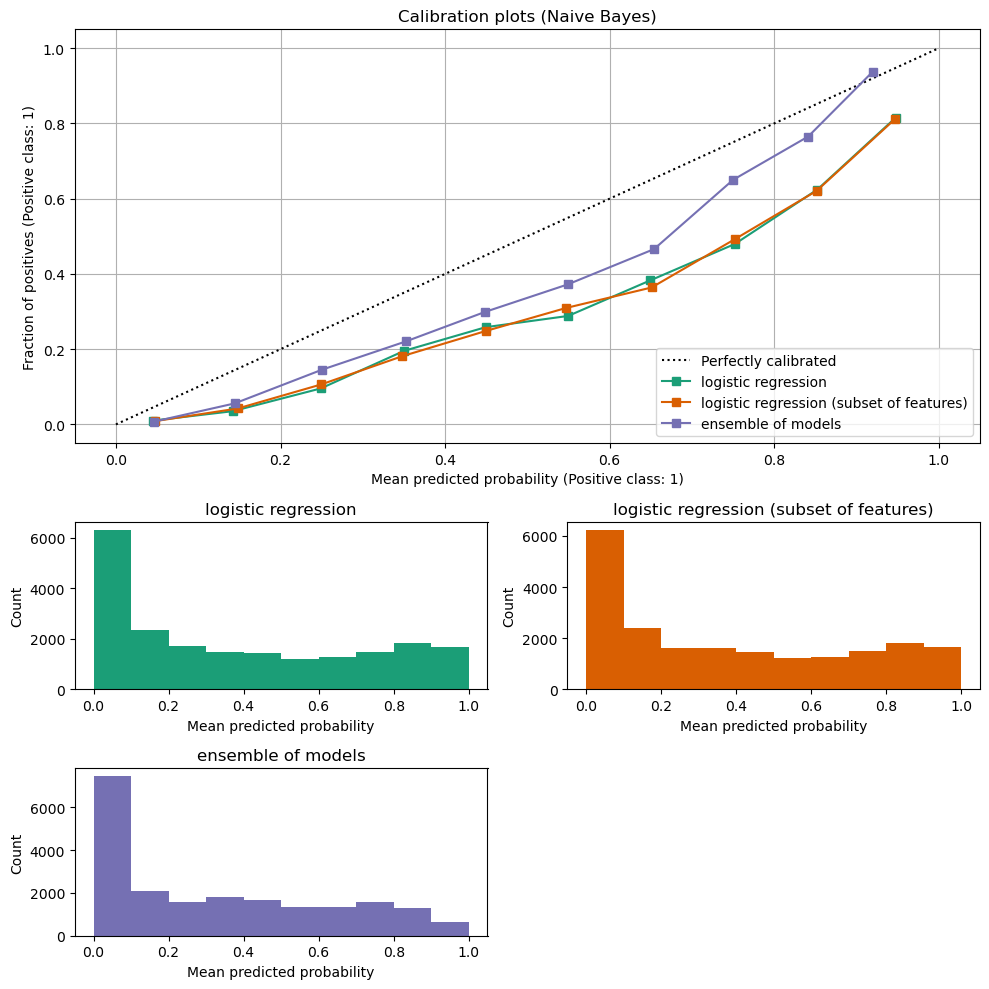

In [34]:
fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.cm.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train, y_train)
    display = CalibrationDisplay.from_estimator(
        clf,
        X_train,
        y_train,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots (reliability curve)")

# Add histogram
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]
for i, (_, name) in enumerate(clf_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

plt.tight_layout()
plt.show()